In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from textblob import TextBlob
from transformers import pipeline
import re

from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_csv('/content/gdrive/MyDrive/Omdena/merge_demo_amos_v3.csv')
print(df.info())
print(df.head())

# Check for missing values
print(df.isnull().sum())






Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7541 entries, 0 to 7540
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Unnamed: 0                 7541 non-null   int64 
 1   disease_name               7541 non-null   object
 2   description                5788 non-null   object
 3   symptoms                   3036 non-null   object
 4   causes                     1022 non-null   object
 5   source                     7541 non-null   object
 6   table_name                 7541 non-null   object
 7   treatment                  2254 non-null   object
 8   url                        904 non-null    object
 9   diagnosis                  1694 non-null   object
 10  medication_name            2314 non-null   object
 11  medication_url             2259 non-null  

In [ ]:
# Tokenization and Stopword Removal
df.dropna(subset=['medication_name'], inplace=True)


nltk.download('punkt_tab')
# Text Preprocessing Function
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    tokens = word_tokenize(text)  # Tokenization
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove stopwords
    return " ".join(tokens)

df['clean_text'] = df['medication_name'].apply(preprocess_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


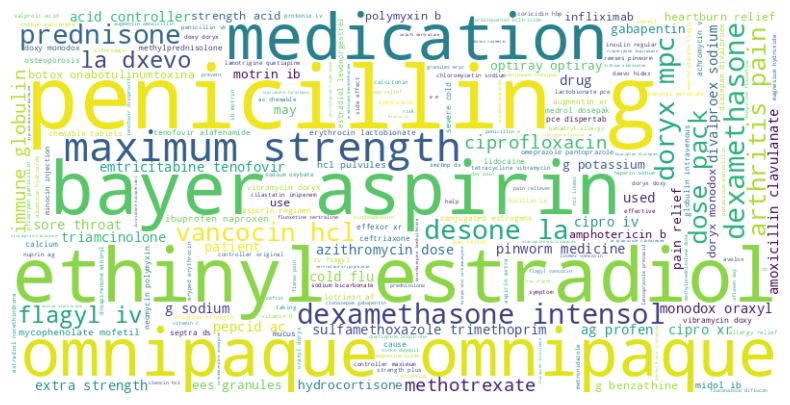

In [ ]:
#Generate Word Cloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df['clean_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:

# Named Entity Recognition (NER) with spaCy
nlp = spacy.load("en_core_web_sm")
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

df['entities'] = df['clean_text'].apply(extract_entities)
print(df[['clean_text', 'entities']].head())


                                      clean_text  \
2               eladocagene exuparvovec kebilidi   
3   sodium bicarbonate citric acidsodium citrate   
7        bethanechol pamabrom urecholine aquaban   
8        bethanechol pamabrom urecholine aquaban   
14                                   vasopressin   

                                            entities  
2       [(eladocagene exuparvovec kebilidi, PERSON)]  
3                                                 []  
7   [(bethanechol pamabrom urecholine aquaban, ORG)]  
8   [(bethanechol pamabrom urecholine aquaban, ORG)]  
14                                                []  


In [ ]:

# Topic Modeling using NMFtfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
# Topic Modeling using NMF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])
nmf = NMF(n_components=5, random_state=42)
nmf.fit(tfidf_matrix)

tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])
nmf = NMF(n_components=5, random_state=42)
nmf.fit(tfidf_matrix)


NMF(n_components=5, random_state=42)

In [ ]:
# Topic Modeling using NMF
def display_topics(model, feature_names, num_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))
        print()

display_topics(nmf, tfidf_vectorizer.get_feature_names_out(), 10)



Topic 0:
doryx penicillin flagyl cipro doxycycline vibramycin azithromycin doxy iv amoxicillin

Topic 1:
dexamethasone prednisone la desone dxevo intensol kenalog triamcinolone zcort clinacort

Topic 2:
fluoxetine citalopram sertraline gabapentin paroxetine risperidone venlafaxine clonazepam escitalopram quetiapine

Topic 3:
praziquantel biltricide paromomycin albenza albendazole mebendazole alinia nitazoxanide pinworm medicine

Topic 4:
aspirin motrin advil bayer pain ibuprofen ib naproxen arthritis voltaren



In [ ]:
# Anomaly Detection -
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))
z_scores = (df['text_length'] - df['text_length'].mean()) / df['text_length'].std()
df['anomaly'] = z_scores.abs() > 3

# Display anomalies
anomalies = df[df['anomaly']]
print(" Anomalies in Prescription Text:")
print(anomalies[['clean_text', 'text_length']])


 Anomalies in Prescription Text:
                                             clean_text  text_length
1154  topical pain medications gels benzocaine oraje...           87
1589  symptoms hay fever allergic rhinitis caused al...          265
2903  oral drugs four oral drugs used stimulate cont...          103
3015  gout medications well tolerated people however...           96
3123  malathion ovide malathion organophosphate inse...          293
4652  mucus cough mucus cough related coughing refle...          127
5141  bisphosphonates decrease risk hip fracture wri...          783
5402  antiplatelet medications aspirin clopidogrel p...          218
6206  regular laboratory work may necessary monitor ...          101
6675  antibiotics quinolones example ciprofloxacin c...           98
6757  keep updated list medications dosages take med...          134
6785  parents endorse topical medicines studies have...          233


: 